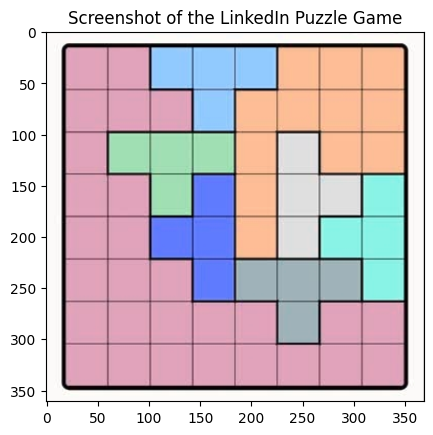

In [1]:
# Imports:
import cv2
import numpy as np
from matplotlib import pyplot as plt, cm

# read Gray image:
Ig = cv2.imread('queens.jpeg', 0)

# read colored image:
Ic = cv2.imread('queens.jpeg')
plt.imshow(Ic, cm.gray)
plt.title('Screenshot of the LinkedIn Puzzle Game');

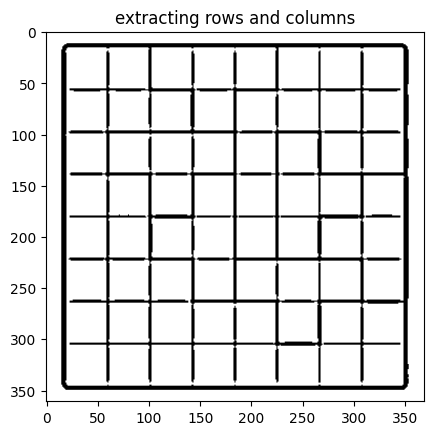

In [2]:
# Binary thresholding on image:
Ig = cv2.GaussianBlur(Ig, (5,5), 0)
B = cv2.adaptiveThreshold(Ig,255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 15, 7)
plt.imshow(B, cm.gray)
plt.title('extracting rows and columns');

In [3]:
# extract cols and rows:
def relu(x):
     return x * (x > 0)
     
G1 = relu(np.diff(B, 1, 0))
G1 = G1.sum(1)

G2 = relu(np.diff(B, 1, 1))
G2 = G2.sum(0)

rows = np.where(G1 > G1.max()*0.5)[0]
cols = np.where(G2 > G2.max()*0.5)[0]

Area = np.zeros((len(rows)-1, len(cols)-1))
Mask = np.zeros_like(Area) - 1

In [4]:
# Convert Playgorund to Numpy array
# Fill mask with labeled regions by colors:
xcenters = np.convolve(rows, (0.5,0.5), 'valid').astype(np.int32)
ycenters = np.convolve(cols, (0.5,0.5), 'valid').astype(np.int32)
x, y = np.meshgrid(xcenters, ycenters)

colors = np.zeros((len(rows)-1, len(cols)-1, 3)) 

for i in range(len(xcenters)):
   for j in range(len(ycenters)):
       colors[j,i] = Ic[x[i,j], y[i,j]]
       
k = 0
for i in range(len(xcenters)):
   for j in range(len(ycenters)):
       if Mask[j, i] == -1:
           N = np.linalg.norm(colors - colors[j,i], 2, axis=2)
           Mask[N < 10] = k
           k += 1
Mask

array([[0., 0., 2., 2., 2., 4., 4., 4.],
       [0., 0., 0., 2., 4., 4., 4., 4.],
       [0., 1., 1., 1., 4., 6., 4., 4.],
       [0., 0., 1., 3., 4., 6., 6., 7.],
       [0., 0., 3., 3., 4., 6., 7., 7.],
       [0., 0., 0., 3., 5., 5., 5., 7.],
       [0., 0., 0., 0., 0., 5., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.]])

# The solution of Queens' Game can be done in an iterative recursive code. See the Code blow:
Here I solve the quest by iteratively check and pruning answers.

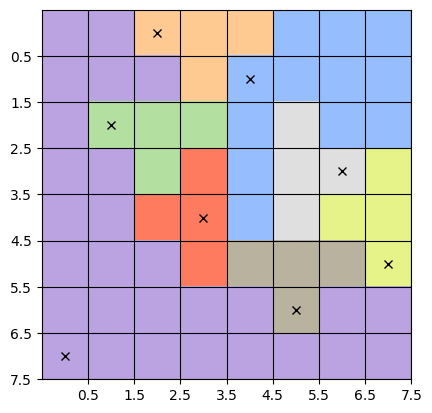

In [5]:
### Solution ==================
Num_regions = k
Area_of_regions = [0] * Num_regions
for i in range(Num_regions):
    Area_of_regions[i] = (Mask == i).sum()

argsort = np.argsort(Area_of_regions)

occupied = set()
used_rows = set()
used_cols = set()
queens = {}


def neighbors(x,y):
    return {(i+di, j+dj) for di in [-1,0,1] for dj in [-1,0,1] if (di != 0 or dj != 0)}


def solve(idx=0):
    global queens, occupied, used_rows, used_cols
    if idx == Num_regions:
        return True
    px, py  = np.where(Mask == argsort[idx])
    for (x,y) in zip(px, py):
        if x in used_rows or y in used_cols:
           continue
        if any((i,j) in occupied for (i,j) in neighbors(x,y)):
           continue
        # place a queen in x, y:
        queens[argsort[idx]] = (x, y)
        used_rows.add(x)
        used_cols.add(y)
        occupied.add((x,y))
        # Recurse:
        if solve(idx+1):
            return True
        # The track failed
        del queens[argsort[idx]]
        used_rows.remove(x)
        used_cols.remove(y)
        occupied.remove((x,y))
    return False
        
p = solve(idx=0)
if p:
   colors = cv2.cvtColor(colors.astype(np.uint8), cv2.COLOR_RGB2BGR)
   plt.imshow(colors, cm.gray)
   for i in range(Num_regions):
       x, y = queens[i]
       plt.plot(y,x, 'k', marker='x')
   plt.xticks(np.arange(len(rows)-1)+0.5)
   plt.yticks(np.arange(len(cols)-1)+0.5)
   plt.grid(color='black')
   plt.show()
else:
   print('there is no solution')

# Now we want to check if it can be solved by Deep Learning.
> Deep learning needs data
> Deep learning needs Labels

But, in this case, I want to use the rules (models) of the Queens' Game to govern my Deep network, which can learn to find answer self-supervised.  
This can be done with knowing how to play and modeling them alongside the deep learning. Just see the code:

In [6]:
import tensorflow as tf
tfk = tf.keras
tfkl = tfk.layers
tfkm = tfk.models
tfko = tfk.optimizers
tfkc = tfk.losses

2025-05-29 22:30:11.308996: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-29 22:30:11.371626: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-29 22:30:11.449915: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748545211.608330  555964 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748545211.642138  555964 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-29 22:30:11.990554: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [7]:
# This is my Base model:

class RegionSoftmax(tfkl.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    def call(self, y_pred):
        Y = tf.split(y_pred, 8, axis=-1)
        Y_pred = []
        for y in Y:
            y = tfkl.Reshape((64,))(y)
            y = tf.nn.softmax(y)
            y = tfkl.Reshape((8,8,1))(y)
            Y_pred.append(y)
        return tfkl.Concatenate(-1)(Y_pred)

inp = tfkl.Input((8,8, 8))
x = tfkl.Conv2D(64, (3,3), padding='same', activation='relu')(inp)
x = tfkl.Conv2D(32, (3,3), padding='same', activation='relu')(x)
x = tfkl.Conv2D(16, (3,3), padding='same', activation='relu')(x)
x = tfkl.Conv2D(8, (1,1), padding='same', activation=None)(x)
out = RegionSoftmax()(x)
model = tfkm.Model(inp, out)

2025-05-29 22:30:19.373225: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


## To model the puzzle game, I defined some loss function which can lead my deep network to learn how to play.
### The first rule (Loss):
Only one queen can be placed in every row and cols. Here the loss definition:

In [8]:
def loss_rowcol(y_pred):
    y_pred = tf.reduce_sum(y_pred, axis=-1)
    row_sum = tf.reduce_sum(y_pred, axis=2)  # [batch, 8]
    col_sum = tf.reduce_sum(y_pred, axis=1)  # [batch, 8]
    row_loss = tf.norm(row_sum-1.0, ord=1) #tf.reduce_mean((row_sum - 1.0) ** 2)
    col_loss = tf.norm(col_sum-1.0, ord=1) #tf.reduce_mean((col_sum - 1.0) ** 2)
    return row_loss + col_loss

### The second rule (Loss):
No two queens can be placed in the same neighborhood. I amplified this penalty by 10.

In [9]:
def neighborhood_sum(pred):
    pred = tf.reduce_sum(pred, axis=-1)
    # pred: [8, 8]
    pad = tf.pad(pred, [[1,1],[1,1]], mode='CONSTANT')  # [10, 10]
    total = (
        pad[0:-2,1:-1] + pad[2:,1:-1] +  # up + down
        pad[1:-1,0:-2] + pad[1:-1,2:]    # left + right
            )
    return tf.reduce_mean(pred * total) *10 # elementwise

### The third rule (Loss):
Every region must have one and only one queen.

In [10]:
def unique_regions(pred, inp):
    K = tf.reduce_sum(pred * inp, axis=(0,1,2))
    return tf.norm(K - tf.ones_like(K), 2)

## Network Input:
I used the ```Mask``` in one-hot coded representation in shape (1, 8, 8, 8).

In [11]:
Inp = tfk.utils.to_categorical(Mask[None,...]).astype(np.float32)

## Now we need a trainer model to train our network:

In [12]:
class queenModel(tfk.Model):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.optimizer = tfko.Adam(learning_rate=1e-5)

    def compile(self, **kwargs):
        super().compile(**kwargs)

        self.uniqe_queens = tfk.metrics.Mean(name='unique_queens')
        self.rowcolloss = tfk.metrics.Mean(name='row_col')
        self.neighbor_loss = tfk.metrics.Mean(name='neighbor_loss')
        
    @property
    def metrics(self):
        return [self.uniqe_queens, self.rowcolloss, self.neighbor_loss]
    
    
    def train_step(self, grid):
        B = 1 #, N = tf.shape(grid)
        with tf.GradientTape() as tape:
           pred = self.model(grid) * grid
           
           l1 = unique_regions(pred, grid)
           l2 = neighborhood_sum(pred[0,...])*10
           l3 = loss_rowcol(pred)*100

           loss = l1 + l2 + l3
        gradients = tape.gradient(loss, self.model.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_weights))

        self.uniqe_queens.update_state(l1)
        self.neighbor_loss.update_state(l2)
        self.rowcolloss.update_state(l3)


        
        return {m.name: m.result() for m in self.metrics}
           
           
QM = queenModel(model)
QM.compile(optimizer=tfko.Adam(learning_rate=1e-4))

In [ ]:
QM.fit(Inp, epochs=500)

In [16]:
QM.fit(Inp, epochs=500)

Epoch 1/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - neighbor_loss: 5.2593 - row_col: 119.7009 - unique_queens: 0.3161
Epoch 2/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - neighbor_loss: 5.2524 - row_col: 118.6967 - unique_queens: 0.3144
Epoch 3/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - neighbor_loss: 5.2473 - row_col: 117.3876 - unique_queens: 0.3122
Epoch 4/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - neighbor_loss: 5.2484 - row_col: 116.7788 - unique_queens: 0.3098
Epoch 5/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - neighbor_loss: 5.2448 - row_col: 116.1675 - unique_queens: 0.3069
Epoch 6/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - neighbor_loss: 5.2363 - row_col: 114.9261 - unique_queens: 0.3042
Epoch 7/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - neighbor_loss: 5.2267 - row_col: 114.7905 - unique_queens: 0.3023
Epoch 8/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - neighbor_loss: 5.2122 - row_col: 113.6165 - unique_queens: 0.3011
Epoch 9/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/st

In [17]:
p = QM.model.predict(Inp) * Inp

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


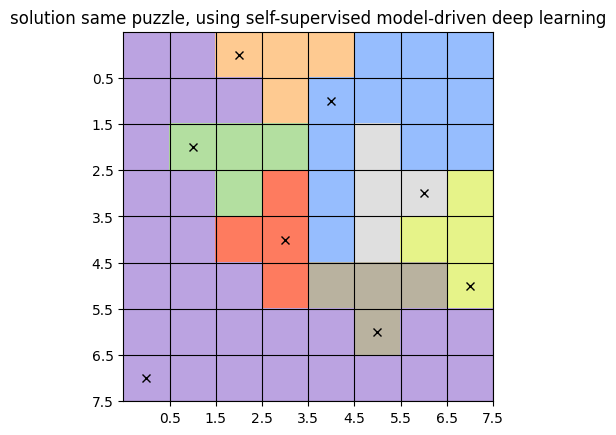

In [18]:
plt.imshow(colors, cm.gray)
for i in range(Num_regions):
     x, y = np.where(p[0,...,i] == p[0,...,i].max())
     plt.plot(y,x, 'k', marker='x')
plt.xticks(np.arange(len(rows)-1)+0.5);
plt.yticks(np.arange(len(cols)-1)+0.5);
plt.grid(color='black')
plt.title('solution same puzzle, using self-supervised model-driven deep learning')
plt.show();